Reviewed: Jan 2024

This notebook may be run in Colab

To run this code on the GPU:

**Runtime -> Change runtime type -> GPU**

# Building a NN using PyTorch

Given an image of a clothing item, we will predict the item.
We will show how to add layers to a NN using [nn.Torch](https://pytorch.org/docs/stable/nn.html), and [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) which
is an ordered container of modules. The data is passed through all the modules in the same order as defined.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F  # For F.relu
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim   # SGD
import time

In [3]:
#Check if GPU is available. The program will run using the GPU if available,
#otherwise will use CPU.
cuda = torch.cuda.is_available()
cuda #returns a Boolean indicating availability of GPU

False

## The Fashion MNIST data

We will use 4096 training images, and 1024 validation images. (Normally, when we train neural networks, we will try to use all the data that we have. The only reason I'm limiting our training and validation set is so that the code runs quickly for demonstration purposes.)

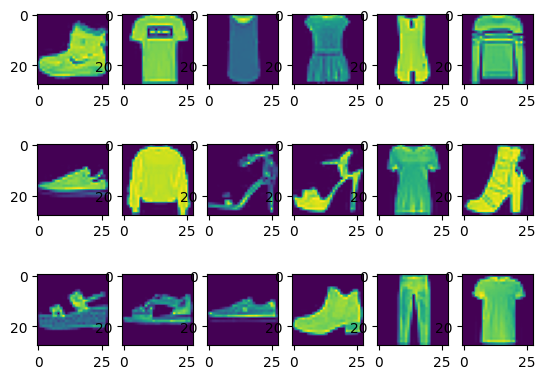

In [4]:
mnist_images = datasets.FashionMNIST('data', train=True, download=True)

for k, (image, label) in enumerate(mnist_images):
    if k >= 18:
        break
    plt.subplot(3, 6, k+1)
    plt.imshow(image)

In [ ]:
# small dataset as example
mnist_data = datasets.FashionMNIST('data', train=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)

mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

In [29]:
# alternative, using whole dataset
mnist_train = datasets.FashionMNIST('data', train=True, transform=transforms.ToTensor())
mnist_train = list(mnist_train)

mnist_val = datasets.FashionMNIST('data', train=False, transform=transforms.ToTensor())
mnist_val = list(mnist_val)


In [30]:
# no. obs in train and validation sets
len(mnist_train), len(mnist_val)

(60000, 10000)

In [10]:
print(len(mnist_train[0])) 
print(mnist_train[0][0].shape) 
print(mnist_train[0][1])

2
torch.Size([1, 28, 28])
9


It means the image in this dataset only have 1 channel, and h = 28, w = 28.

## **LeNet**


In [11]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),        
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

Structure: several convolutional layers extract local information, followed by several fully-connected layers to 'mix' those information.

## **Test the model**

By passing a single-channel (black and white) image through the network and printing the output shape at each layer, we can inspect the model to make sure that its what we expect.

In [12]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in model:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [19]:
# For this class, it's optional to use the GPU

#Set up device to do computation. Device is either cpu or gpu.
#Set device = gpu if gpu available
device = torch.device("cuda" if cuda else "cpu")

#Transfer model to device. (Also have to transfer data to device, which will do later)
model.to(device)
print(model)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


## Training

In [ ]:
num_workers = 3 if cuda else 0

# This train function expects train_data and val_data to be lists of data, the corresponding dataloader 
# will be constructed in the function then. 
def train(model, train_data, val_data, batch_size=64, num_epochs=1, lr=0.01):
    device = torch.device("cuda" if cuda else "cpu")
    model = model.to(device)
    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    model.apply(init_weights)

    def get_accuracy(model, data_loader):
        model.eval()
        correct, total = 0, 0
        for imgs, labels in data_loader:
            # Transfer data to device
            imgs, labels = imgs.to(device), labels.to(device)
            # Evaluate
            output = model(imgs)
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]
        model.train()
        return correct / total

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False, num_workers=num_workers)

    #Pick loss and optimiser to use in training
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=lr) 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    #Store evaluation metrics
    iters, losses, train_acc, val_acc = [], [], [], []

    # Training loop
    n = 0 # the number of iterations
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_loss = 0
        #Iterate over the mini-batches
        for imgs, labels in iter(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass: outputs logits for each image and computes the loss value
            out = model(imgs)
            loss = criterion(out, labels)

            # Backward pass and update
            loss.backward()               # Backprop
            optimizer.step()              # Update each parameter

            epoch_loss += loss.item()
            n += 1

        # Compute accuracy after each epoch
        iters.append(n)
        losses.append(epoch_loss / len(train_loader))                                   # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy

        #End of an epoch
        end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {round(losses[-1],5)}, Train Acc: {round(train_acc[-1],5)}, \
              Val Acc: {round(val_acc[-1],5)}, Time: {round(end_time - start_time,5)}s')

    # plotting
    plt.figure()
    plt.title("Training Loss Curve")
    plt.plot(iters, losses, label="Loss")
    plt.xlabel("Iterations (number of epochs)")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # plot accuracy curve
    plt.title("Training & Validation Accuracy")
    plt.plot(iters, train_acc, label="Train Acc")
    plt.plot(iters, val_acc, label="Validation Acc")
    plt.xlabel("Iterations (number of epochs)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print("Final Training Accuracy:", train_acc[-1])
    print("Final Validation Accuracy:", val_acc[-1])

`get_accuracy` helper function. To turn the probabilities into a discrete prediction, we will take the digit with the highest probability. Because of the way softmax is computed, the digit with the highest probability is the same as the digit with the (pre-activation) output value.

60000 10000
Epoch 1/50 - Loss: 2.23947, Train Acc: 0.50053,               Val Acc: 0.503, Time: 8.21154s
Epoch 2/50 - Loss: 1.22164, Train Acc: 0.64577,               Val Acc: 0.6422, Time: 16.21552s
Epoch 3/50 - Loss: 0.88596, Train Acc: 0.70092,               Val Acc: 0.6949, Time: 24.1922s
Epoch 4/50 - Loss: 0.76023, Train Acc: 0.72788,               Val Acc: 0.7204, Time: 33.14713s
Epoch 5/50 - Loss: 0.69218, Train Acc: 0.74665,               Val Acc: 0.7397, Time: 41.20563s
Epoch 6/50 - Loss: 0.65443, Train Acc: 0.75457,               Val Acc: 0.7482, Time: 49.28318s
Epoch 7/50 - Loss: 0.62857, Train Acc: 0.76145,               Val Acc: 0.754, Time: 57.83398s
Epoch 8/50 - Loss: 0.60889, Train Acc: 0.77177,               Val Acc: 0.7629, Time: 66.29032s
Epoch 9/50 - Loss: 0.59013, Train Acc: 0.7809,               Val Acc: 0.7734, Time: 75.41015s
Epoch 10/50 - Loss: 0.5759, Train Acc: 0.7872,               Val Acc: 0.7792, Time: 84.08006s
Epoch 11/50 - Loss: 0.55863, Train Acc: 0.77

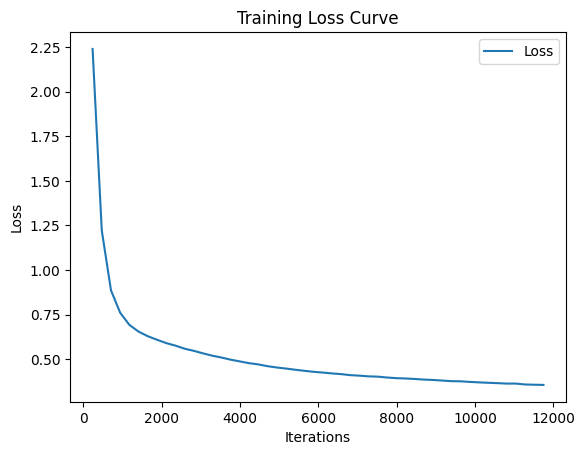

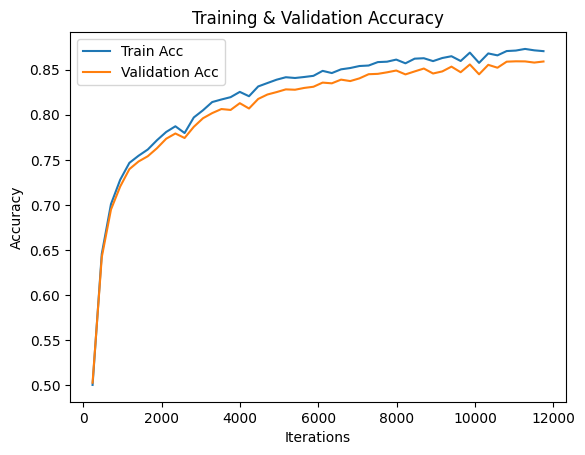

Final Training Accuracy: 0.8704666666666667
Final Validation Accuracy: 0.859


In [31]:
print(len(mnist_train), len(mnist_val))

train(model, train_data=mnist_train, val_data=mnist_val, batch_size=256, num_epochs=50, lr=0.0005)

## Debugging

One technique that researchers often use to debug their network is to first make sure that their network can overfit to a small dataset. This sanity check ensures that you are using the right variable names, and rules out other programming bugs that are difficult to discern from architecture issues.

Common programming issues that can arise include:

Forgetting to call optimizer.zero_grad() when using PyTorch. In general, this line of code is included at the beginning of the code for a training iteration, as opposed to at the end.
Using the wrong criterion, or using a loss function with incorrectly formated variables.
Adding a non-linearity after the final layer. In general we don't add a non-linearity in the forward function of the network, so that the computation of the loss function and the associated optimization steps are more numerically stable.
Forgetting non-linearity layers in the forward function.

Training Loss in epoch 1/100: 0.03611, Time: 0.28997s
Training Loss in epoch 2/100: 0.03605, Time: 0.52717s
Training Loss in epoch 3/100: 0.03599, Time: 0.75452s
Training Loss in epoch 4/100: 0.03594, Time: 0.99111s
Training Loss in epoch 5/100: 0.03589, Time: 1.18338s
Training Loss in epoch 6/100: 0.03584, Time: 1.36017s
Training Loss in epoch 7/100: 0.0358, Time: 1.53473s
Training Loss in epoch 8/100: 0.03575, Time: 1.70688s
Training Loss in epoch 9/100: 0.03571, Time: 1.87182s
Training Loss in epoch 10/100: 0.03567, Time: 2.05023s
Training Loss in epoch 11/100: 0.03563, Time: 2.22975s
Training Loss in epoch 12/100: 0.0356, Time: 2.40538s
Training Loss in epoch 13/100: 0.03556, Time: 2.5846s
Training Loss in epoch 14/100: 0.03553, Time: 2.76694s
Training Loss in epoch 15/100: 0.0355, Time: 2.94686s
Training Loss in epoch 16/100: 0.03547, Time: 3.12572s
Training Loss in epoch 17/100: 0.03544, Time: 3.30037s
Training Loss in epoch 18/100: 0.03541, Time: 3.47998s
Training Loss in epoch 

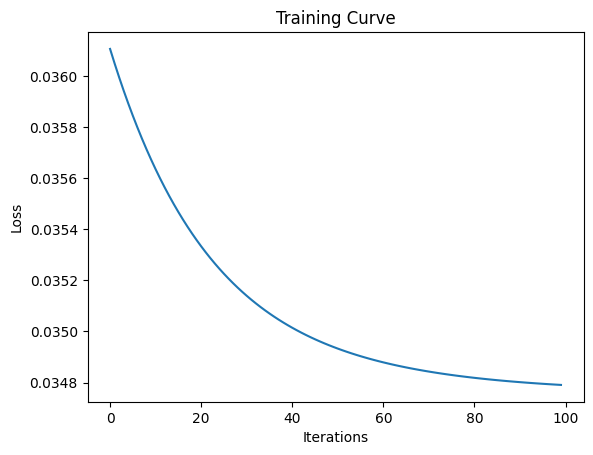

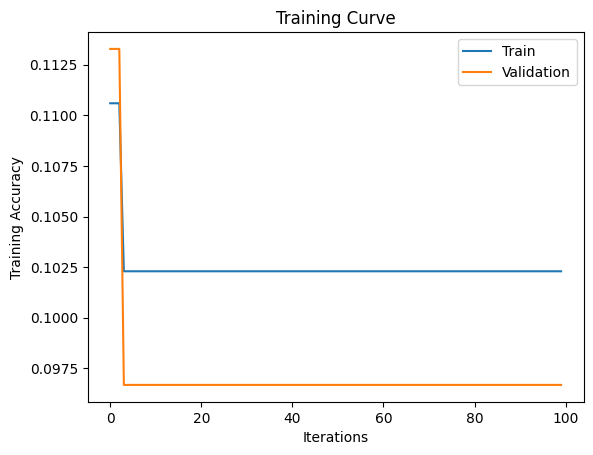

Final Training Accuracy: 0.102294921875
Final Validation Accuracy: 0.0966796875


In [25]:
debug_data = mnist_train[:64] #sample size = batch size
train(model, debug_data, num_epochs=100)

Only when we have ensured that our model can overfit to a small dataset do we begin training the neural network our full training set.

Training Loss in epoch 1/100: 0.03595, Time: 0.6988s
Training Loss in epoch 2/100: 0.03605, Time: 1.31415s
Training Loss in epoch 3/100: 0.03589, Time: 1.92061s
Training Loss in epoch 4/100: 0.03581, Time: 2.59985s
Training Loss in epoch 5/100: 0.03596, Time: 3.26211s
Training Loss in epoch 6/100: 0.03599, Time: 3.86395s
Training Loss in epoch 7/100: 0.03599, Time: 4.45679s
Training Loss in epoch 8/100: 0.03603, Time: 5.05458s
Training Loss in epoch 9/100: 0.03601, Time: 5.64887s
Training Loss in epoch 10/100: 0.03586, Time: 6.24983s
Training Loss in epoch 11/100: 0.03597, Time: 6.84366s
Training Loss in epoch 12/100: 0.03612, Time: 7.45432s
Training Loss in epoch 13/100: 0.03595, Time: 8.21735s
Training Loss in epoch 14/100: 0.036, Time: 8.84131s
Training Loss in epoch 15/100: 0.03593, Time: 9.45028s
Training Loss in epoch 16/100: 0.036, Time: 10.0723s
Training Loss in epoch 17/100: 0.03603, Time: 10.67407s
Training Loss in epoch 18/100: 0.03608, Time: 11.26783s
Training Loss in epoch

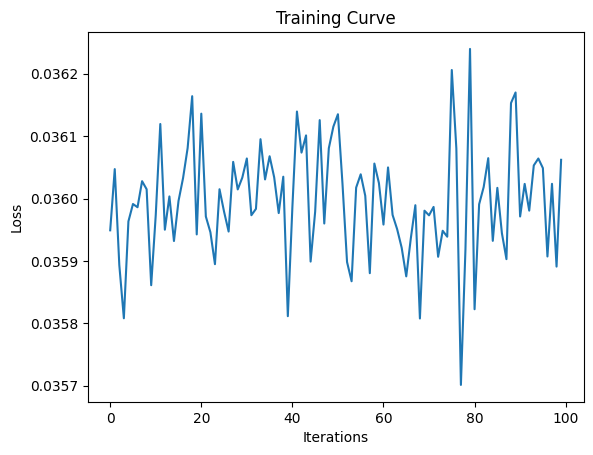

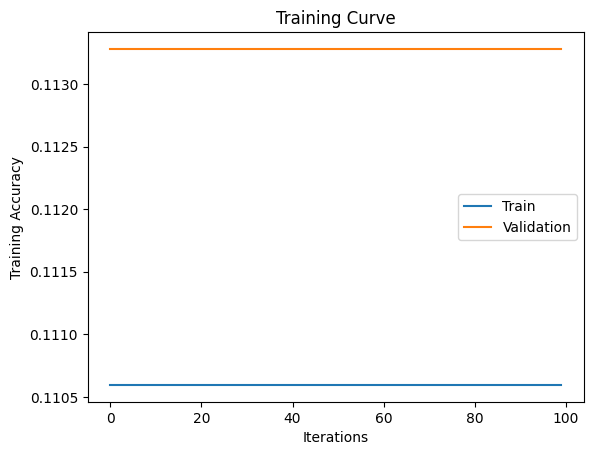

Final Training Accuracy: 0.110595703125
Final Validation Accuracy: 0.11328125


In [24]:
train(model, mnist_train, num_epochs=100)


## Going further

At this point, we can begin tuning hyperparameters, and tweak the architecture of our network to improve our validation accuracy. We can also check for any underfitting or overfitting. We will see how to do this in the next few lectures and classes.